In [1]:
import astropy
from astropy.table import Table, join, vstack
from astropy.time import Time
from astropy.io import fits
from astropy import units as u

from astroquery.jplhorizons import Horizons

import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import time
import requests
import sys
import os
import getpass

saveplots = False # set to save some of the plots to png files
import pandas as pd
from astropy.time import Time
from astropy.coordinates import SkyCoord
from urllib.parse import quote

# Functions

In [2]:
def cadc_ssos_query(object_name, search="bynameall", 
                    # epoch1=50000, epoch2=57079,
                    xyres="no", 
                    # telinst="Pan-STARRS1", 
                    lang="en", format="tsv",
                    url="https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl"):
    """Use CADC moving object query to find PS1 observations by target name
    
    The epoch parameters give the range in MJD for the PS1 observations.
    The only parameter that might be usefully modified is the search.  
    E.g., use search="bynameHorizons" to search using the JPL Horizons emphemeris rather
    than the ephemeris cached at CADC.  That might be useful if the CADC cache has become
    out-of-date.
    
    This return an astropy table with the observations.
    """
    t0 = Time('1990-01-01 00:00:00', format='iso', scale='utc')
    t1 = Time.now()

    print(f"Querying CADC SSOS for object '{object_name}' between {t0.iso} and {t1.iso}")
    params = dict(
        lang=lang,
        object=object_name,
        search=search,
        epoch1=t0.mjd,
        epoch2=t1.mjd,
        format=format
    )

    try:
        r = requests.get(url, params=params, timeout=60)
    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed: {e}")
        # Return an empty table with expected columns so downstream code doesn't crash
        cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
        return Table.from_pandas(pd.DataFrame(columns=cols))

    print(r.url)

    text = r.text
    first_line = text.strip().split('\n', 1)[0]

    # Detect common error responses from CADC / Horizons and HTML error pages
    if (first_line.lower().startswith("there was an error") or
        "error" in first_line.lower() or
        first_line.strip().startswith("<!DOCTYPE") or
        first_line.strip().startswith("<html")):
        # Clean up message for printing
        msg = first_line.replace('<br/>', '').strip()
        print(f"CADC/SSOS returned an error: {msg}")
        # Try a simple fallback: switch to CADC cached ephemerides if not already using it
        if search != "bynameCADC":
            print("Retrying with search='bynameCADC'...")
            return cadc_ssos_query(object_name, search="bynameCADC", xyres=xyres, lang=lang, format=format, url=url)
        # Otherwise return an empty table with expected columns
        cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
        return Table.from_pandas(pd.DataFrame(columns=cols))

    # Parse TSV using pandas to avoid astropy fast C-reader converter limitations
    try:
        df = pd.read_csv(StringIO(text), sep='\t', engine='python', on_bad_lines='skip')
    except Exception as e:
        print(f"Failed to parse CADC TSV: {e}")
        # Return empty table with expected columns to keep pipeline running
        cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
        return Table.from_pandas(pd.DataFrame(columns=cols))

    # Ensure expected columns exist even if CADC response changes
    expected_cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                     'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
    for col in expected_cols:
        if col not in df.columns:
            df[col] = pd.NA

    # Ensure string type for Image_target if present
    if 'Image_target' in df.columns:
        df['Image_target'] = df['Image_target'].astype(str)

    return Table.from_pandas(df)



In [3]:
# Define a simple ephemerides query
def ephemcc(ident, ep, nbd=None, step=None, observer='645', rplane='1', tcoor=5):
    '''Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :ep: float, str, list - Epoch of computation
    :observer: str - IAU Obs code - default to geocenter: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    '''
    
    # ------
    # Miriade URL 
    url = 'https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php'
    
    #if rplane=='2':
    #    tcoor='1'
        
    # Query parameters
    params = {
        '-name': f'c:{ident}',
        '-mime': 'json',
        '-rplane': rplane,
        '-tcoor': tcoor,
        '-output': '--jd',
        '-observer': observer, 
        '-tscale': 'UTC',
        '-type': 'Asteroid'
    }
    

    # Single epoch of computation
    if type(ep)!=list:
        # Set parameters
        params['-ep'] = ep
        if nbd!=None: 
            params['-nbd'] = nbd
        if step!=None: 
            params['-step'] = step

        # Execute query
        try:
            r = requests.post(url, params=params, timeout=80)
        except requests.exceptions.ReadTimeout:
            return False


    # Multiple epochs of computation
    else:
        # Epochs of computation
        files = {'epochs': ('epochs', '\n'.join(['%.6f' % epoch
                                                 for epoch in ep]))}

        # Execute query
        try:
            r = requests.post(url, params=params, files=files, timeout=120)
            print(r.url)
        except requests.exceptions.ReadTimeout:
            return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j['data'])
    except KeyError:
        return False

    return ephem


# List of the comets

In [3]:
df_init = pd.read_csv('data/List of comets.csv')
df_init

,Comet name,q,e,Tq,year of observations
0,C/2021 S3,1.320,1.00025,14.02.2024,"2024, 2025"
1,C/2019 L3,3.550,1.00141,09.01.2022,"2024, 2025"
2,C/2019 U5,3.620,1.00142,29.03.2023,"2024, 2025"
3,C/2022 N2,3.830,1.00356,31.07.25,"2024, 2025"
4,C/2019 T4,4.240,0.99562,08.06.2022,"2024, 2025"
5,C/2017 K2,1.800,1.00060,19.12.2022,"2020, 2021, 2024, 2025"
6,C/2022 QE78,5.480,1.00405,10.09.2025,"2024, 2025"
7,C/2022 E2,3.670,1.00073,14.09.2024,"2024, 2025"
8,C/2024 E1,0.566,1.00005,20.01.2026,"2024, 2025"
9,C/2021 G2,4.982,1.00011,09.09.2024,"2024, 2025"


# Read tables from CADC

In [73]:
%%time 
for i, row in df_init.iterrows():
    print(f"{i}: {row['Comet name']}")
    source = df_init.loc[i, 'Comet name']
    name = " ".join(source.split())

    cadc_tab = cadc_ssos_query(name)
    print(f"Returned table has {len(cadc_tab)} rows")
    df_comet = cadc_tab.to_pandas()
    df_comet.to_csv(f"data/cadc/{name.replace('/', '_')}_cadc.csv", index=False)
    # break



0: C/2021 S3
Querying CADC SSOS for object 'C/2021 S3' between 1990-01-01 00:00:00.000 and 2025-09-22 11:51:56.764
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2021+S3&search=bynameall&epoch1=47892.0&epoch2=60940.49440698593&format=tsv
Returned table has 2400 rows
1: C/2019 L3
Querying CADC SSOS for object 'C/2019 L3' between 1990-01-01 00:00:00.000 and 2025-09-22 11:52:03.622
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2019+L3&search=bynameall&epoch1=47892.0&epoch2=60940.49448636738&format=tsv
Returned table has 2724 rows
2: C/2019 U5
Querying CADC SSOS for object 'C/2019 U5' between 1990-01-01 00:00:00.000 and 2025-09-22 11:52:11.453
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2019+U5&search=bynameall&epoch1=47892.0&epoch2=60940.49457700529&format=tsv
Returned table has 1826 rows
3: C/2022 N2
Querying CADC SSOS for object 'C/2022 N2' between 1990-01-01 00

# Check Miriade

In [16]:
rows_limit = 500
for i, row in df_init[1:].iterrows():
    print(f"{i}: {row['Comet name']}")
    source = df_init.loc[i, 'Comet name']
    name = " ".join(source.split())
    filename = f"data/cadc/{name.replace('/', '_')}_cadc.csv"
    df_obs = pd.read_csv(filename)
    
    chunks = len(df_obs) // rows_limit + 1
    print(f"  Read {len(df_obs)} observations from {filename} in {chunks} chunks")

    df_comet = None
    for chunk in range(chunks):
        start = chunk * rows_limit
        end = min((chunk + 1) * rows_limit, len(df_obs))
        jds = (df_obs['MJD'].values[start:end] + 2400000.5).tolist()
        
        ephem = ephemcc(name, jds, observer='500', rplane='1', tcoor=5)
        if ephem is False:
            print(f"  Miriade query failed for {name}")
            continue
        
        if df_comet is None:
            df_comet = ephem
        else:
            df_comet = pd.concat([df_comet, ephem], ignore_index=True)

    if df_comet is not None:
        print(f"Got {len(df_comet)} ephemeris rows from Miriade")
        df_comet.to_csv(f"data/miriade/{name.replace('/', '_')}_miriade.csv", index=False)

    

1: C/2019 L3
  Read 2724 observations from data/cadc/C_2019 L3_cadc.csv in 6 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-

# Analysis of the results

In [36]:
counts = 0
for i, row in df_init[0:].iterrows():
    name = " ".join(row['Comet name'].split())
    cadc_filename = f"data/cadc/{name.replace('/', '_')}_cadc.csv"
    miriade_filename = f"data/miriade/{name.replace('/', '_')}_miriade.csv"
    try:
        df_cadc = pd.read_csv(cadc_filename)
    except FileNotFoundError:
        print(f"{name}: CADC file not found")
        continue
    
    try:
        df_miriade = pd.read_csv(miriade_filename)
    except FileNotFoundError:
        print(f"{name}: Miriade file not found")
        continue
    
    df = pd.merge(df_cadc, df_miriade, left_index=True, right_index=True, suffixes=('_cadc', '_miriade'))
    print(f"{name}: merged {len(df)} rows")
    
    cond = (df['VMag'] < 18) & (df["Telescope/Instrument"] == "NEOSSat")
    df_visible = df[cond]
    counts += len(df_visible)
    # break
print(f"Total visible observations: {counts}")

C/2021 S3: merged 2400 rows
C/2019 L3: merged 2724 rows
C/2019 U5: merged 1826 rows
C/2022 N2: merged 2802 rows
C/2019 T4: merged 1769 rows
C/2017 K2: merged 7173 rows
C/2022 QE78: merged 2666 rows
C/2022 E2: merged 1331 rows
C/2024 E1: merged 1362 rows
C/2021 G2: merged 1582 rows
C/2023 Q1: Miriade file not found
C/2023 H5: merged 921 rows
C/2010 U3: merged 662 rows
C/2012 K2: Miriade file not found
C/2013 V2: merged 607 rows
C/2014 N3: merged 646 rows
C/2014 S2: merged 679 rows
C/2014 W2: merged 726 rows
C/2015 O1: merged 973 rows
C/2015 V2: merged 1210 rows
C/2015 VL62: Miriade file not found
C/2016 N4: merged 1650 rows
C/2017 O1: merged 4258 rows
C/2018 N2: merged 1730 rows
C/2018 U1: merged 1119 rows
C/2020 M3: merged 1306 rows
C/2020 T2: merged 1214 rows
C/2021 A2: merged 957 rows
110P: merged 2528 rows
114P: merged 1404 rows
123P: merged 1237 rows
12P: merged 2387 rows
156P: merged 1173 rows
201P: merged 2542 rows
21P: merged 1775 rows
230P: merged 689 rows
260P: merged 1821 row

In [34]:
df_visible.value_counts('Telescope/Instrument')

Telescope/Instrument
NEOSSat              1533
LCO/lsc_1m0a_fa15      13
ESA-CAHA               12
CTIO-4m/DECam           8
ESA-TBT-LaSilla         8
LCO/lsc_0m4a_kb29       8
LCO/coj_2m0a_fs01       6
LCO/cpt_1m0a_fa16       6
CFHT/MegaCam            5
LCO/cpt_1m0a_fa06       4
LCO/lsc_1m0a_fa04       4
LCO/tfn_1m0a_fa20       4
ALMA                    1
Name: count, dtype: int64

In [ ]:
# for i, row in df_init[5:].iterrows():
#     name = " ".join(row['Comet name'].split())
#     cadc_filename = f"data/cadc/{name.replace('/', '_')}_cadc.csv"
#     miriade_filename = f"data/miriade/{name.replace('/', '_')}_miriade.csv"

Telescope/Instrument
NEOSSat              1443
ZTF                   403
CFHT/MegaCam          108
ESA-CAHA               99
LCO/tfn_0m4a_kb95      88
LCO/tfn_0m4b_kb56      68
HST/WFC3               63
ESA-TBT-LaSilla        60
LCO/tfn_0m4b_kb98      50
LCO/elp_1m0a_fa05      43
LCO/elp_0m4a_kb92      38
LCO/lsc_0m4a_kb98      30
ALMA                   23
Gemini/GMOS            21
LCO/ogg_0m4b_kb27      20
LCO/tfn_0m4a_kb81      20
LCO/cpt_1m0a_fa06      18
LCO/lsc_0m4a_kb26      18
LCO/elp_0m4a_kb55      16
LCO/cpt_1m0a_fa16      15
LCO/lsc_1m0a_fa15      15
WHT/AUXCAM             10
HST/ACS                10
CTIO-4m/DECam           8
LCO/coj_1m0a_fa12       7
ESA-TBT-Cebreros        6
LCO/tfn_1m0a_fa11       4
LCO/elp_1m0a_fa07       4
LCO/tfn_0m4b_kb23       4
LCO/coj_0m4a_kb26       4
LCO/lsc_1m0a_fa04       3
LCO/tfn_1m0a_fa20       3
ESA-Tautenburg          2
LCO/lsc_0m4a_kb29       2
LCO/tfn_0m4a_kb25       2
Name: count, dtype: int64

# New list of the comets

In [4]:
l2 = "C/2004 D1, C/2005 R4, C/2005 T3, C/2006 L1, C/2006 Q1, C/2007 N3, C/2007 R1, C/2008 FK75, C/2009 F2, C/2009 S3, C/2009 U5, C/2010 G2, C/1212 A1, C/2016 R2, C/2023 H5"
df_init = pd.DataFrame({"Comet": l2.split(", ")})
df_init

,Comet
0,C/2004 D1
1,C/2005 R4
2,C/2005 T3
3,C/2006 L1
4,C/2006 Q1
5,C/2007 N3
6,C/2007 R1
7,C/2008 FK75
8,C/2009 F2
9,C/2009 S3


In [9]:
%%time 
for i, row in df_init.iterrows():
    print(f"{i}: {row['Comet']}")
    source = df_init.loc[i, 'Comet']
    name = " ".join(source.split())

    cadc_tab = cadc_ssos_query(name)
    print(f"Returned table has {len(cadc_tab)} rows")
    df_comet = cadc_tab.to_pandas()
    df_comet.to_csv(f"data/cadc2/{name.replace('/', '_')}_cadc.csv", index=False)
    # break


0: C/2004 D1
Querying CADC SSOS for object 'C/2004 D1' between 1990-01-01 00:00:00.000 and 2025-10-09 07:30:09.554
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2004+D1&search=bynameall&epoch1=47892.0&epoch2=60957.31261057771&format=tsv
Returned table has 957 rows
1: C/2005 R4
Querying CADC SSOS for object 'C/2005 R4' between 1990-01-01 00:00:00.000 and 2025-10-09 07:30:17.522
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2004+D1&search=bynameall&epoch1=47892.0&epoch2=60957.31261057771&format=tsv
Returned table has 957 rows
1: C/2005 R4
Querying CADC SSOS for object 'C/2005 R4' between 1990-01-01 00:00:00.000 and 2025-10-09 07:30:17.522
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2005+R4&search=bynameall&epoch1=47892.0&epoch2=60957.31270280004&format=tsv
Returned table has 590 rows
2: C/2005 T3
Querying CADC SSOS for object 'C/2005 T3' between 1990-01-01 00:00

In [16]:
rows_limit = 2000
for i, row in df_init[1:].iterrows():
    print(f"{i}: {row['Comet']}")
    source = df_init.loc[i, 'Comet']
    name = " ".join(source.split())
    filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
    df_obs = pd.read_csv(filename)
    
    chunks = len(df_obs) // rows_limit + 1
    print(f"  Read {len(df_obs)} observations from {filename} in {chunks} chunks")

    df_comet = None
    for chunk in range(chunks):
        start = chunk * rows_limit
        end = min((chunk + 1) * rows_limit, len(df_obs))
        jds = (df_obs['MJD'].values[start:end] + 2400000.5).tolist()
        
        ephem = ephemcc(name, jds, observer='500', rplane='1', tcoor=5)
        if ephem is False:
            print(f"Miriade query failed for {name}")
            time.sleep(1)
            continue
        
        if df_comet is None:
            df_comet = ephem
        else:
            df_comet = pd.concat([df_comet, ephem], ignore_index=True)

    if df_comet is not None:
        print(f"Got {len(df_comet)} ephemeris rows from Miriade")
        df_comet.to_csv(f"data/miriade2/{name.replace('/', '_')}_miriade.csv", index=False)

1: C/2005 R4
  Read 590 observations from data/cadc2/C_2005 R4_cadc.csv in 1 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2005+R4&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
Got 590 ephemeris rows from Miriade
2: C/2005 T3
  Read 1871 observations from data/cadc2/C_2005 T3_cadc.csv in 1 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2005+R4&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
Got 590 ephemeris rows from Miriade
2: C/2005 T3
  Read 1871 observations from data/cadc2/C_2005 T3_cadc.csv in 1 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2005+T3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
Miriade query failed for C/2005 T3
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2005+T3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-t

In [19]:
counts = 0
for i, row in df_init[0:].iterrows():
    name = " ".join(row['Comet'].split())
    cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
    miriade_filename = f"data/miriade2/{name.replace('/', '_')}_miriade.csv"
    try:
        df_cadc = pd.read_csv(cadc_filename)
    except FileNotFoundError:
        print(f"{name}: CADC file not found")
        continue
    
    try:
        df_miriade = pd.read_csv(miriade_filename)
    except FileNotFoundError:
        print(f"{name}: Miriade file not found")
        continue
    
    df = pd.merge(df_cadc, df_miriade, left_index=True, right_index=True, suffixes=('_cadc', '_miriade'))
    print(f"{name}: merged {len(df)} rows")
    display(df.value_counts('Telescope/Instrument'))
    
    cond = (df['VMag'] < 18) # & (df["Telescope/Instrument"] == "NEOSSat")
    df_visible = df[cond]
    counts += len(df_visible)
    # break
print(f"Total visible observations: {counts}")

C/2004 D1: Miriade file not found
C/2005 R4: merged 590 rows


Telescope/Instrument
WISE                   168
Pan-STARRS1            119
ZTF                    105
Skymapper               60
NEOSSat                 32
ESO-VISTA/VIRCAM        24
INT/WFC                 20
CTIO-4m/DECam           12
CFHT/MegaCam             9
ESA-LSSS-Centurion2      9
LCO/cpt_1m0a_fa06        7
LCO/cpt_1m0a_fa16        7
LCO/coj_1m0a_fa12        6
NEAT-GEODSS-Maui         6
ALMA                     5
LCO/elp_1m0a_fa07        1
Name: count, dtype: int64

C/2005 T3: Miriade file not found
C/2006 L1: merged 903 rows


Telescope/Instrument
WISE                    295
ZTF                     235
CTIO-4m/DECam           147
Pan-STARRS1             113
ESA-CAHA                 53
ESA-LSSS-Centurion3      15
SDSS                     15
ESA-LSSS-Centurion2      12
ALMA                      6
ESO-VST/OMEGACAM          6
ESA-LSSS-Centurion1       3
ESO-LaSilla_2.2m/WFI      2
Subaru/HSC                1
Name: count, dtype: int64

C/2006 Q1: merged 788 rows


Telescope/Instrument
WISE                   354
ZTF                    275
Pan-STARRS1            108
ESO-NTT/EMMI            18
INT/WFC                 14
SDSS                    10
KPNO-0.9m/Mosaic1.1      3
ALMA                     2
LCO/ogg_0m4b_kb27        2
CFHT/MegaCam             1
KPNO-4m/Mosaic1.1        1
Name: count, dtype: int64

C/2007 N3: merged 895 rows


Telescope/Instrument
WISE                    269
ZTF                     224
Pan-STARRS1             131
CTIO-4m/DECam            53
ESA-CAHA                 40
CFHT/MegaCam             39
Subaru/HSC               30
ESO-NTT/EFOSC            18
Subaru/SuprimeCam        16
ALMA                     16
ESA-OGS-ESACCD2          13
NEAT-GEODSS-Maui         12
ESA-LSSS-Centurion2      12
ESA-LSSS-Centurion1       9
ESO-VST/OMEGACAM          5
ESO-LaSilla_2.2m/WFI      4
ESA-LSSS-Centurion3       3
NEOSSat                   1
Name: count, dtype: int64

C/2007 R1: Miriade file not found
C/2008 FK75: merged 1368 rows


Telescope/Instrument
CTIO-4m/DECam          541
WISE                   284
ZTF                    221
Pan-STARRS1            120
Gemini/GMOS             85
ESO-VISTA/VIRCAM        54
ESA-LSSS-Centurion2     20
Subaru/HSC              12
LCO/lsc_1m0a_fl15       10
ESA-LSSS-Centurion1      9
ESA-LSSS-Centurion3      6
ALMA                     3
Skymapper                2
LCO/tfn_0m4a_kb29        1
Name: count, dtype: int64

C/2009 F2: merged 716 rows


Telescope/Instrument
WISE                   265
ZTF                    260
Pan-STARRS1            124
KPNO-2.3m/90prime       12
CFHT/MegaCam            10
ESA-LSSS-Centurion1      9
ESA-CAHA                 8
ESA-LSSS-Centurion2      6
SOAR/SOI                 6
ALMA                     5
LCO/elp_1m0a_fa05        4
ESA-LSSS-Centurion3      3
LCO/tfn_0m4a_kb29        2
NEOSSat                  2
Name: count, dtype: int64

C/2009 S3: merged 1032 rows


Telescope/Instrument
WISE                    379
LCO/lsc_1m0a_kb11       127
CTIO-4m/DECam           126
Pan-STARRS1             121
ZTF                      80
ESO-LaSilla_2.2m/WFI     57
ESO-VISTA/VIRCAM         54
Skymapper                29
ESA-LSSS-Centurion2      24
NEAT-GEODSS-Maui         15
ALMA                      3
CFHT/MegaCam              3
ESA-LSSS-Centurion3       3
ESA-LSSS-Centurion1       3
LCO/tfn_0m4a_kb25         2
Subaru/SuprimeCam         2
LCO/coj_0m4a_kb24         2
LCO/ogg_0m4c_kb82         1
ESA-TBT-LaSilla           1
Name: count, dtype: int64

C/2009 U5: merged 623 rows


Telescope/Instrument
WISE                   184
CTIO-4m/DECam          172
Pan-STARRS1            128
ZTF                    111
Skymapper               10
ALMA                     8
ESA-LSSS-Centurion1      6
ESA-LSSS-Centurion2      3
NEOSSat                  1
Name: count, dtype: int64

C/2010 G2: merged 828 rows


Telescope/Instrument
WISE                    496
CTIO-4m/DECam           122
ESO-VISTA/VIRCAM         94
Pan-STARRS1              54
ESO-VLT/FORS2            36
CFHT/MegaCam              8
Skymapper                 8
ESA-TBT-LaSilla           6
ESO-LaSilla_2.2m/WFI      2
NEOSSat                   2
Name: count, dtype: int64

C/1212 A1: Miriade file not found
C/2016 R2: merged 1823 rows


Telescope/Instrument
CTIO-4m/DECam        487
WISE                 405
NEOSSat              147
ESA-TBT-LaSilla      123
ESO-VISTA/VIRCAM     100
ZTF                   98
LCO/cpt_0m4a_kb96     98
LCO/tfn_0m4b_kb88     50
ESO-VST/OMEGACAM      40
LCO/elp_0m4a_kb94     36
INT/WFC               32
LCO/ogg_0m4c_kb82     26
LCO/ogg_0m4b_kb27     24
LCO/ogg_2m0a_fs02     24
Skymapper             22
CFHT/MegaCam          21
Gemini/GMOS           21
WHT/AUXCAM            12
LCO/elp_1m0a_fl05     12
LCO/tfn_0m4a_kb99     12
LCO/coj_2m0a_fs01     12
LCO/lsc_1m0a_fl03     10
LCO/lsc_1m0a_kb69      8
LCO/coj_0m4b_kb97      2
ALMA                   1
Name: count, dtype: int64

C/2023 H5: merged 921 rows


Telescope/Instrument
WISE                 508
ESO-VISTA/VIRCAM     161
ESA-Schiaparelli      98
CTIO-4m/DECam         75
LCO/lsc_0m4a_kb29     21
Skymapper             20
ESA-OGS-ESACCD2       12
ESA-Klet              10
LCO/cpt_0m4a_kb84      6
ESA-TBT-LaSilla        5
CFHT/MegaCam           3
ALMA                   1
NEOSSat                1
Name: count, dtype: int64

Total visible observations: 1637


# Plots

In [5]:
# name= "C/2023 H5"
name = "C/2006 L1"
cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
miriade_filename = f"data/miriade2/{name.replace('/', '_')}_miriade.csv"
try:
    df_cadc = pd.read_csv(cadc_filename)
except FileNotFoundError:
    print(f"{name}: CADC file not found")
    df_cadc = pd.DataFrame()
try:    df_miriade = pd.read_csv(miriade_filename)
except FileNotFoundError:
    print(f"{name}: Miriade file not found")
    df_miriade = pd.DataFrame()
df = pd.merge(df_cadc, df_miriade, left_index=True, right_index=True, suffixes=('_cadc', '_miriade'))
print(f"{name}: merged {len(df)} rows")
df

C/2006 L1: merged 903 rows


,Image,MJD,Filter,Exptime,Object_RA,Object_Dec,Image_target,Telescope/Instrument,MetaData,Datalink,...,RA,DEC,Dobs,Dhelio,VMag,Phase,Elong.,dRAcosDEC,dDEC,RV
0,frame-r-007791-4-0058,54774.246462,r,54,328.952852,27.536789,frame-r-007791-4-0058,SDSS,http://data.sdss3.org/sas/dr9/boss/photoObj/fr...,NaN,...,+21:55:48.6417,+27:32:12.009,7.393672,7.848812,25.892622,6.630344,113.955486,-0.111185,-0.278519,34.732418
1,frame-r-007791-4-0059,54774.246877,r,54,328.952832,27.536743,frame-r-007791-4-0059,SDSS,http://data.sdss3.org/sas/dr9/boss/photoObj/fr...,NaN,...,+21:55:48.6367,+27:32:11.842,7.393681,7.848815,25.892628,6.630358,113.955152,-0.111182,-0.278518,34.732525
2,frame-i-007791-4-0058,54774.247291,i,54,328.952811,27.536697,frame-i-007791-4-0058,SDSS,http://data.sdss3.org/sas/dr9/boss/photoObj/fr...,NaN,...,+21:55:48.6317,+27:32:11.676,7.393689,7.848819,25.892633,6.630372,113.954819,-0.111180,-0.278518,34.732632
3,frame-i-007791-4-0059,54774.247706,i,54,328.952791,27.536651,frame-i-007791-4-0059,SDSS,http://data.sdss3.org/sas/dr9/boss/photoObj/fr...,NaN,...,+21:55:48.6267,+27:32:11.510,7.393697,7.848822,25.892639,6.630386,113.954484,-0.111177,-0.278517,34.732739
4,frame-u-007791-4-0058,54774.248120,u,54,328.952770,27.536605,frame-u-007791-4-0058,SDSS,http://data.sdss3.org/sas/dr9/boss/photoObj/fr...,NaN,...,+21:55:48.6217,+27:32:11.344,7.393706,7.848825,25.892645,6.630399,113.954151,-0.111175,-0.278516,34.732846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,c4d_240901_012003_opi_i_v1.fits.fz a7a1a05dc59...,60554.056116,i,90,313.761021,8.998121,DELVE field: 5073-03-i,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,+20:55:02.6762,+08:59:53.277,35.796438,36.659378,36.089324,0.827781,148.347422,-0.059827,-0.031586,15.985617
899,c4d_240908_003800_ori.fits.fz 8b3fef950ee0f644...,60561.026911,i,90,313.597981,8.907193,DELVE field: 5065-04-i,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,+20:54:23.5446,+08:54:25.944,35.866927,36.686107,36.099450,0.926462,143.931149,-0.055554,-0.033551,19.005339
900,c4d_240908_003800_oki_i_v1.fits.fz 980b37b41e5...,60561.026911,i,90,313.597981,8.907193,DELVE field: 5065-04-i,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,+20:54:23.5446,+08:54:25.944,35.866927,36.686107,36.099450,0.926462,143.931149,-0.055554,-0.033551,19.005339
901,c4d_240908_003800_ooi_i_v1.fits.fz a797f4b6d63...,60561.026911,i,90,313.597981,8.907193,DELVE field: 5065-04-i,CTIO-4m/DECam,https://astroarchive.noirlab.edu/api/retrieve/...,NaN,...,+20:54:23.5446,+08:54:25.944,35.866927,36.686107,36.099450,0.926462,143.931149,-0.055554,-0.033551,19.005339


Have C/2006 L1 from 2008-11-04T05:54:54.308 to 2024-09-08T00:38:45.090 (5787 days)
Got positions from Horizons with 5438 rows for Lemmon (C/2023 H5)


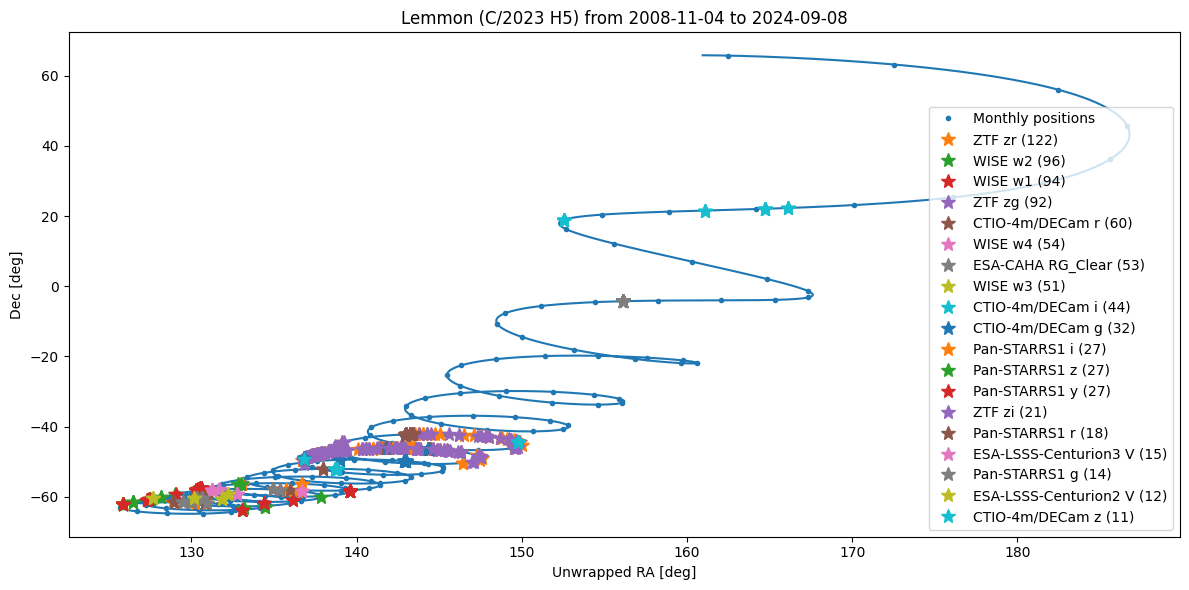

In [6]:
# %%time 

# PS1 epoch range with epoch edges set to round days
emin = Time(df['MJD'].min(), format='mjd')
emax = Time(df['MJD'].max(), format='mjd')

print(f"Have {name} from {emin.isot} to {emax.isot} ({emax.mjd-emin.mjd:.0f} days)")

# query using 1-day time steps
obj = Horizons(id=name, location='500', 
               epochs=dict(start=emin.isot, stop=emax.isot, step='1d'))#, 

jpltab = obj.ephemerides(extra_precision=True)
fullname = jpltab['targetname'][0]
print(f"Got positions from Horizons with {len(jpltab)} rows for {fullname}")


Have C/2006 L1 from 2008-11-04T05:54:54.308 to 2024-09-08T00:38:45.090 (5787 days)
Got positions from Horizons with 5787 rows for Garradd (C/2006 L1)


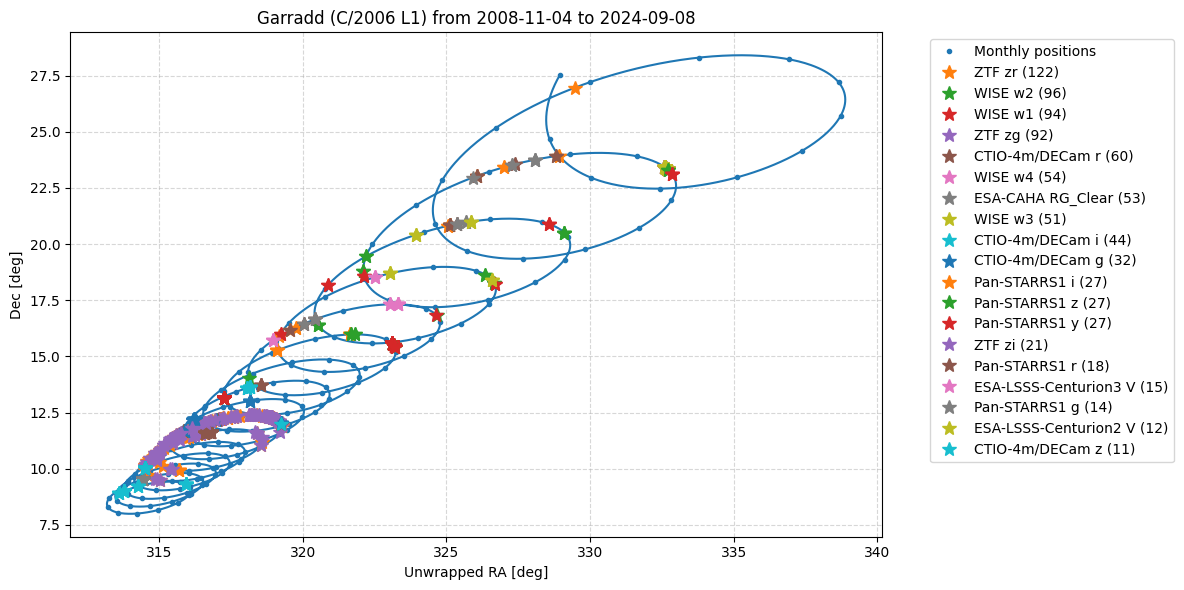

In [7]:

# undo RA-wrapping from 0-360 degrees
# add or subtract multiples of 360 to create a smooth path
# jpltab = Table.from_pandas(df)
njumps = 0
ratab = jpltab['RA'].data.copy()
w = np.where(ratab[1:] > ratab[:-1]+180)[0]
for k in w:
    njumps += 1
    ratab[k+1:] -= 360
    
w = np.where(ratab[1:] < ratab[:-1]-180)[0]
for k in w:
    njumps += 1
    ratab[k+1:] += 360
while ratab.min() < 0:
    ratab += 360

# plt.rcParams.update({"font.size":14})
plt.figure(1,(12,6))
plt.plot(ratab, jpltab['DEC'])

# plot every 30 days as a dot to see movement
mstep = int(30/(jpltab['datetime_jd'][1]-jpltab['datetime_jd'][0]) + 0.5)
plt.plot(ratab[::mstep], jpltab['DEC'][::mstep], '.', color="tab:blue", label="Monthly positions")

# show positions at the times of observations
jpl_mjd = Time(jpltab['datetime_jd'],format='jd').mjd
ra_interp = np.interp(df['MJD'], jpl_mjd, ratab)
dec_interp = np.interp(df['MJD'], jpl_mjd, jpltab['DEC'])

df_instr = df[['Telescope/Instrument', 'Filter']].value_counts()
df_instr = df_instr[df_instr > 10]
for (instr, filt), count in df_instr.items():
    cond = (df['Telescope/Instrument'] == instr) & (df['Filter'] == filt)
    plt.plot(ra_interp[cond], dec_interp[cond], '*', markersize=10,
             label=f"{instr} {filt} ({count})")
# plt.plot(ra_interp, dec_interp, 'o', color="tab:orange", label=f"{len(df)} observations")

plt.xlabel("Unwrapped RA [deg]")
plt.ylabel("Dec [deg]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"{fullname} from {emin.isot[:10]} to {emax.isot[:10]}")
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.5)
# if saveplots:
#     plt.savefig("sky_path.png", facecolor="white")
plt.show()

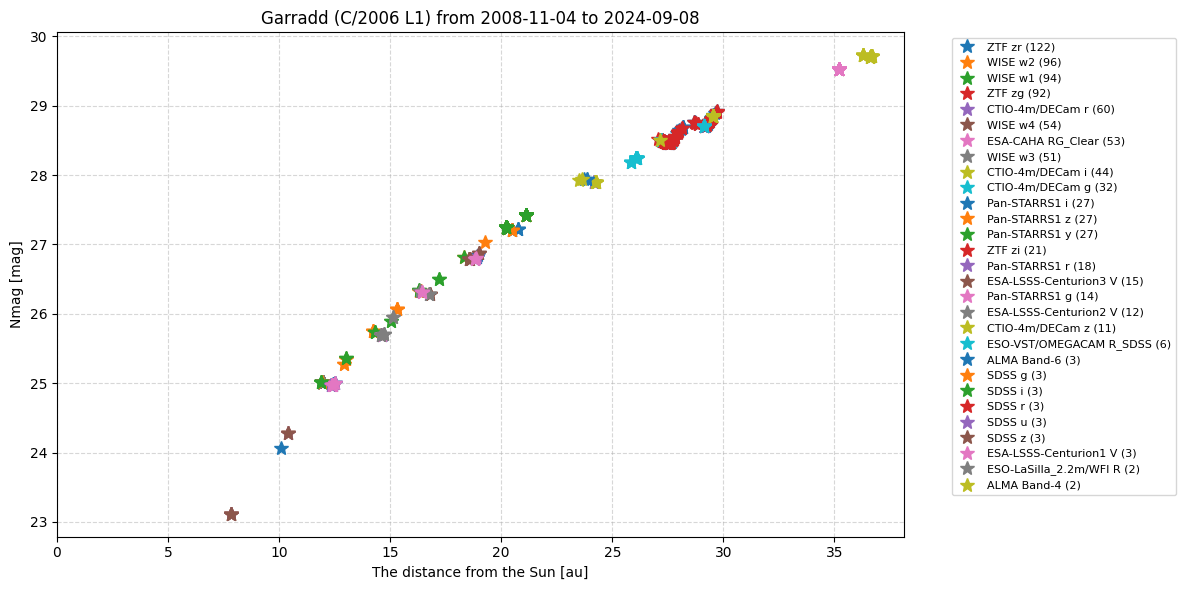

In [8]:
phase_interp = np.interp(df['MJD'], jpl_mjd, jpltab['alpha_true']) 
# Nmag
nmag_interp = np.interp(df['MJD'], jpl_mjd, jpltab['Nmag'])
# distance from the Sun
r_interp = np.interp(df['MJD'], jpl_mjd, jpltab['r'])

# plt.rcParams.update({"font.size":14})
plt.figure(1,(12,6))
# plt.plot(ratab, jpltab['DEC'])

df_instr = df[['Telescope/Instrument', 'Filter']].value_counts()
df_instr = df_instr[df_instr > 1]
for (instr, filt), count in df_instr.items():
    cond = (df['Telescope/Instrument'] == instr) & (df['Filter'] == filt)
    plt.plot(
        # phase_interp[cond], 
        r_interp[cond],
         nmag_interp[cond], 
        '*', markersize=10,
        label=f"{instr} {filt} ({count})")
# plt.plot(ra_interp, dec_interp, 'o', color="tab:orange", label=f"{len(df)} observations")

plt.xlabel("The distance from the Sun [au]")
plt.ylabel("Nmag [mag]")
plt.xlim(left=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.title(f"{fullname} from {emin.isot[:10]} to {emax.isot[:10]}")
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.5)
# if saveplots:
#     plt.savefig("sky_path.png", facecolor="white")
plt.show()


Telescope/Instrument  Filter    
WISE                  w1            183
                      w2            183
ESO-VISTA/VIRCAM      KS            155
ESA-Schiaparelli      Clear          98
WISE                  w4             72
                      w3             70
CTIO-4m/DECam         g              40
                      r              20
ESA-OGS-ESACCD2       IRBlock        12
CTIO-4m/DECam         i              11
ESA-Klet              none           10
LCO/lsc_0m4a_kb29     rp              7
                      ip              7
                      gp              7
ESO-VISTA/VIRCAM      J               6
ESA-TBT-LaSilla       R               4
CTIO-4m/DECam         z               4
Skymapper             z               4
                      g               4
                      i               4
                      r               4
CFHT/MegaCam          GRI.MP9605      3
Skymapper             u               3
LCO/cpt_0m4a_kb84     rp              2
       

In [37]:
jpltab

targetname,datetime_str,datetime_jd,M1,M2,k1,k2,phasecoeff,solar_presence,lunar_presence,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,Tmag,Nmag,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,mag,mag,---,---,mag / deg,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,h,---,mag,mag,mag,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,h,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,h,deg,deg,deg
str19,str24,float64,float64,float64,float64,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,int64,float64,str1,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
Garradd (C/2006 L1),2008-Nov-04 05:54:54.308,2454774.746461898,8.7,14.1,21.75,5.0,0.03,,,328.95260071,27.536715517,329.05574842,27.582975843,-6.66275,-16.7163,--,--,--,--,379208.958,155079.483,66.259,--,999,--,32.506,23.117,99.66549,--,410261.0,*,--,--,--,--,--,264.42,0.0,--,--,350.368441,34.815241,7.848804737804,13.4995583,7.39366632885955,34.7323844,61.4912478,14.9745057,43.8714943,113.9614,/T,6.6297,62.0,32.0685,59.5038,84.42,37.128,-3.96561,Peg,65.182543,342.8933006,37.3093117,--,--,81.749363,-20.960541,--,0.0,1.863,1.269,2.226,0.354,33.672,2.4779649,2.254,16221.8836,0.0003927,2.64,9.59,0.108221,129.0733,--,6.6313,346.6273,36.1211
Garradd (C/2006 L1),2008-Nov-05 05:54:54.308,2454775.746461898,8.7,14.1,21.75,5.0,0.03,,,328.903827668,27.425715662,329.006954878,27.471950885,-6.30221,-16.5936,--,--,--,--,375040.033,155775.509,66.396,--,999,--,32.522,23.126,99.66219,--,407354.9,*,--,--,--,--,--,263.62,0.0,--,--,350.336003,34.809277,7.856598964939,13.494318,7.41379876565315,34.9863725,61.65868417,14.9669954,43.8952097,113.1541,/T,6.6624,53.0,41.2361,60.279,83.629,37.2,-3.91251,Peg,65.182558,342.7843835,37.2275476,--,--,81.635888,-21.015136,--,0.0,1.863,1.274,2.229,0.354,33.786,2.4764657,2.257,16235.8233,0.0003926,2.7,9.83,0.108314,129.1008,--,6.664,346.5553,36.0784
Garradd (C/2006 L1),2008-Nov-06 05:54:54.308,2454776.746461898,8.7,14.1,21.75,5.0,0.03,,,328.857803377,27.315547748,328.960901955,27.361753414,-5.94349,-16.4664,--,--,--,--,370877.342,156458.717,66.511,--,999,--,32.537,23.135,99.659,--,404434.8,*,--,--,--,--,--,262.85,0.0,--,--,350.303634,34.803317,7.864390161493,13.4890849,7.43407547579093,35.2320119,61.82732043,14.9594992,43.915861,112.343,/T,6.6939,45.0,50.893,61.0592,82.851,37.277,-3.85844,Peg,65.182573,342.6788182,37.1454445,--,--,81.524822,-21.070582,--,0.0,1.862,1.278,2.231,0.353,33.899,2.4747502,2.259,16250.154,0.0003925,2.77,10.07,0.108409,129.1281,--,6.6955,346.485,36.0355
Garradd (C/2006 L1),2008-Nov-07 05:54:54.308,2454777.746461898,8.7,14.1,21.75,5.0,0.03,,,328.814507647,27.206241158,328.917569356,27.252413499,-5.58675,-16.3349,--,--,--,--,366721.503,157128.811,66.606,--,999,--,32.552,23.144,99.6559